## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

## 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異

In [1]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\nien\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 3
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [13]:
results = {}
for i in BATCH_SIZE:
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=i, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    name = 'BATCH_SIZE %s' %(i)
    results[name] = {
        'train_loss':train_loss,
        'valid_loss':valid_loss,
        'train_acc':train_acc,
        'valid_acc':valid_acc
    }

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 5s 101us/step - loss: 1.8765 - acc: 0.3560 - val_loss: 1.7433 - val_acc: 0.3837
Epoch 2/3
50000/50000 [==============================] - 4s 85us/step - loss: 1.5484 - acc: 0.4583 - val_loss: 1.6352 - val_acc: 0.4240
Epoch 3/3
50000/50000 [==============================] - 4s 85us/step - loss: 1.4426 - acc: 0.4954 - val_loss: 1.5380 - val_acc: 0.4535


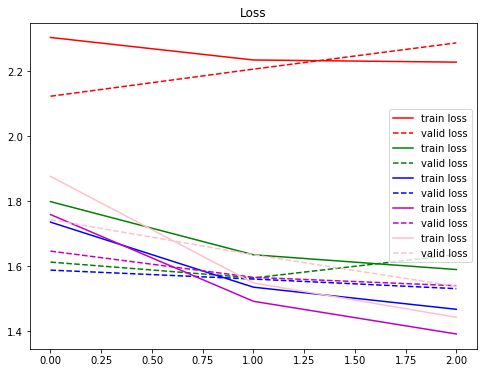

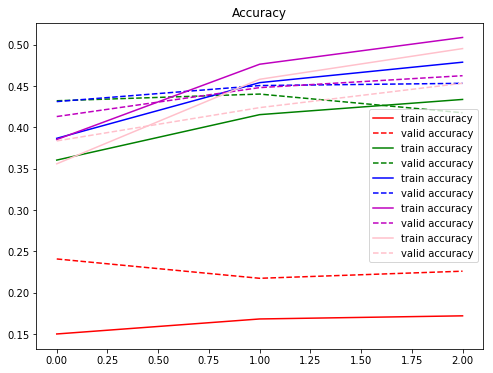

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['r','g','b','m','pink']

plt.figure(figsize = (8,6))
for i,cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], "-",label="train loss",color = color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'], "--",label="valid loss",color = color_bar[i])
plt.legend()
plt.title("Loss")
plt.show()

plt.figure(figsize = (8,6))
for i,cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], "-",label="train accuracy",color = color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], "--",label="valid accuracy",color = color_bar[i])
plt.legend()
plt.title("Accuracy")
plt.show()

## 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [21]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [22]:
LEARNING_RATE = 1e-3
EPOCHS = 3
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [23]:
keras.backend.clear_session()
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total para

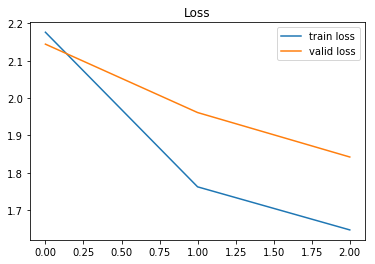

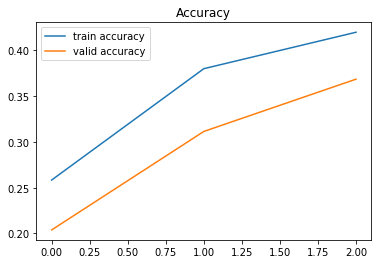

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## 請於 BN 放在 Input Layer 後，並比較結果

In [25]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)

    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [26]:
LEARNING_RATE = 1e-3
EPOCHS = 3
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [27]:
keras.backend.clear_session()
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,751,178
Trainable params: 1,745,034
Non-trainable params: 6,144
______________________________________________________________

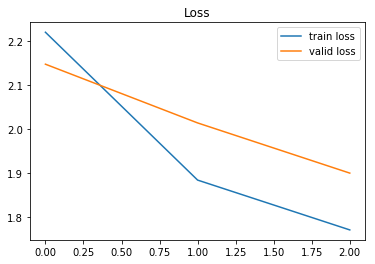

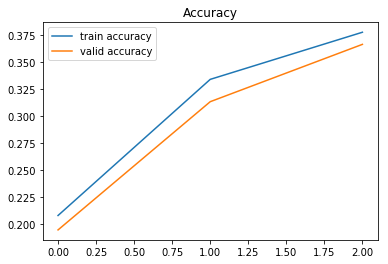

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()